**Installation of SimPy""
If not available**

In [186]:
#!pip install simpy
#!pip install numpy

**Import of required modules**

In [187]:
import simpy
import numpy as np
import numpy.random as random

**Parameters settings**

In [188]:
MAXSIMTIME = 10000
VERBOSE = False
LAMBDA = 7
MU = 8
POPULATION = 50000000
SERVICE_DISCIPLINE = 'FIFO'
LOGGED = True
PLOTTED = True

**Discrete-Event Simulation model**


**The definition of a job**.

The properties of a job are


1. job execution time
2. job arrival time

In [189]:
class Job:
    def __init__(self, name, arrtime, duration):
        self.name = name
        self.arrtime = arrtime
        self.duration = duration

    def __str__(self):
        return '%s at %d, length %d' %(self.name, self.arrtime, self.duration)

**Disciplines**
Different queue disciplines can be defined here.


1.   Shortest Job First (SJF)
2.   List item



In [190]:
def SJF( job ):
    return job.duration

**The definition of server**

 There are 2 arguments needed for a server:
 1. env: SimPy environment
 2. queue discipline: 
   - FIFO: First In First Out
   - SJF : Shortest Job First

In [191]:
class Server:
    def __init__(self, env, strat = 'FIFO'):
        self.env = env
        self.strat = strat
        self.Jobs = list(())
        self.serversleeping = None
        self.serverRunning = None
        ''' statistics '''
        self.waitingTime = 0
        self.squareWaitingTime = 0
        self.idleTime = 0
        self.jobsDone = 0
        self.responseTime = 0
        self.squareResponseTime = 0
        self.firstService = 0
        self.preRunPoint = 0
        self.numOfJobInSys = 0
        self.squareNumOfJobInSys = list()
        self.numOfJobInQ = 0
        self.squareNumOfJobInQ = list()
        ''' register a new server process '''
        env.process( self.serve() )

    def serve(self):
        while True:
            ''' do nothing, just change server to idle
              and then yield a wait event which takes infinite time
            '''
            if len( self.Jobs ) == 0 :
                self.serversleeping = env.process( self.waiting( self.env ))
                t1 = self.env.now
                yield self.serversleeping
                ''' accumulate the server idle time'''
                self.idleTime += self.env.now - t1
            else:
                ''' get the first job to be served'''
                if self.strat == 'SJF':
                    self.Jobs.sort( key = SJF )
                    j = self.Jobs.pop( 0 )
                else: # FIFO by default
                    j = self.Jobs.pop( 0 )
                if LOGGED:
                    qlog.write( '%.4f\t%d\t%d\n' 
                        % (self.env.now, 1 if len(self.Jobs)>0 else 0, len(self.Jobs)) )

                ''' sum up the waiting time'''
                self.waitingTime += self.env.now - j.arrtime
                self.squareWaitingTime += (self.env.now - j.arrtime)**2
                ''' yield an event for the job finish'''
                self.serverRunning = self.env.process(self.running(self.env, j.duration))
                yield self.serverRunning
                ''' sum up the jobs done '''
                self.jobsDone += 1

                # tinh response time
                self.responseTime += self.env.now - j.arrtime
                self.squareResponseTime += (self.env.now - j.arrtime)**2
                # tinh khoang cach thoi gian
                tempTime = self.env.now - self.preRunPoint
                if tempTime < 0:
                    raise Exception("tempTime < 0,",tempTime)
                # tong job trong he thong trong khoang thoi gian tempTime
                self.numOfJobInSys += (len(self.Jobs) + 1) * tempTime
                self.squareNumOfJobInSys.append((len(self.Jobs) + 1) * tempTime)
                self.numOfJobInQ += len(self.Jobs) * tempTime
                self.squareNumOfJobInQ.append(len(self.Jobs) * tempTime)
                # cap nhat preRunPoint
                self.preRunPoint = self.env.now

    def waiting(self, env):
        try:
            if VERBOSE:
                print( 'Server is idle at %.2f' % self.env.now )
            yield self.env.timeout( MAXSIMTIME )
        except simpy.Interrupt as i:
            if VERBOSE:
                 print('Server waken up and works at %.2f' % self.env.now )
    def running(self, env, duration):
        yield env.timeout(duration)

**The arrival process**

The arrival process is exponentially distributed which is parameterized by
1. number of servers
2. maximum number of population
3. arrival rate $\lambda$
4. service rate $\mu$
*Note that, the implementation of the arrival process embeds both arrival and service distributions.*

In [192]:
class JobGenerator:
    def __init__(self, env, server, nrjobs = 10000000, lam = 5, mu = 8):
        self.server = server
        self.nrjobs = nrjobs
        self.interarrivaltime = 1/lam;
        self.servicetime = 1/mu;
        env.process( self.generatejobs(env) )
        
    def generatejobs(self, env):
        i = 1
        while True:
            '''yield an event for new job arrival'''
            job_interarrival = random.exponential( self.interarrivaltime )
            yield env.timeout( job_interarrival )

            tempTime = env.now - self.server.preRunPoint
            if tempTime < 0:
                raise Exception("tempTime < 0,",tempTime)
            if self.server.serverRunning is not None and not self.server.serverRunning.triggered:
                self.server.numOfJobInSys += tempTime * (len(self.server.Jobs) + 1)
                self.server.squareNumOfJobInSys.append((tempTime * len(self.server.Jobs) + 1))
            else:
                self.server.numOfJobInSys += tempTime * len(self.server.Jobs)
                self.server.squareNumOfJobInSys.append(tempTime * len(self.server.Jobs))
            

            self.server.numOfJobInQ += tempTime * len(self.server.Jobs)
            self.server.squareNumOfJobInQ.append(tempTime * len(self.server.Jobs))
            self.server.preRunPoint = env.now

            ''' generate service time and add job to the list'''
            job_duration = random.exponential( self.servicetime )
            self.server.Jobs.append( Job('Job %s' %i, env.now, job_duration) )
            if VERBOSE:
                print( 'job %d: t = %.2f, l = %.2f, dt = %.2f' 
                    %( i, env.now, job_duration, job_interarrival ) )
            i += 1

            ''' if server is idle, wake it up'''
            if not self.server.serversleeping.triggered:
                self.server.serversleeping.interrupt( 'Wake up, please.' )


**Open the log file**

If requested.

In [193]:
if LOGGED:
    qlog = open( 'mm1-l%d-m%d.csv' % (LAMBDA,MU), 'w' )
    qlog.write( '0\t0\t0\n' )

**Start SimPy environment**

In [194]:
env = simpy.Environment()
MyServer = Server( env, SERVICE_DISCIPLINE )
MyJobGenerator = JobGenerator( env, MyServer, POPULATION, LAMBDA, MU )

**Run the simulation** 

In [195]:
env.run( until = MAXSIMTIME )

**Close the log file**

In [196]:
if LOGGED:
    qlog.close()

**Print some statistics**

In [197]:
RHO = LAMBDA/MU
print( 'Arrivals               : %d' % (MyServer.jobsDone) )
print( 'Utilization            : %.2f/%.2f' 
    % (1.0-MyServer.idleTime/MAXSIMTIME, RHO) )
print( 'Mean waiting time      : %.2f/%.2f' 
    % (MyServer.waitingTime/MyServer.jobsDone, RHO**2/((1-RHO)*LAMBDA) ) )
print (f'Variance of waiting time \
       {MyServer.squareWaitingTime/MyServer.jobsDone - (MyServer.waitingTime/MyServer.jobsDone)**2}/ \
           {((2-RHO)*RHO)/(MU**2 * (1 - RHO)**2)}')
print( 'Mean response time     : %.2f/%.2f'
    % (MyServer.responseTime/MyServer.jobsDone, (1/MU)/(1 - RHO)))
print (f'Variance of response time \
       {MyServer.squareResponseTime/MyServer.jobsDone - (MyServer.responseTime/MyServer.jobsDone)**2}/ \
           {1/(MU**2 * (1 - RHO)**2)}')
# print( 'Mean number of jobs    : %.2f/%.2f'
#     % (LAMBDA * MyServer.responseTime / MyServer.jobsDone, RHO/(1 - RHO)))
# print( 'Mean number of jobs in queue : %.2f/%.2f'
#     % (LAMBDA * (MyServer.waitingTime/MyServer.jobsDone), RHO**2 / (1 - RHO)))
print( 'Mean number of jobs    : %.2f/%.2f'
    % (MyServer.numOfJobInSys / MAXSIMTIME, RHO/(1 - RHO)))
# print( 'Variance number of jobs    : %.3f/%.3f'
#     % (MyServer.squareNumOfJobInSys/MAXSIMTIME - (MyServer.numOfJobInSys / MAXSIMTIME)**2, 
#        RHO/(1 - RHO)**2))
print( 'Mean number of jobs in queue : %.2f/%.2f'
    % (MyServer.numOfJobInQ / MAXSIMTIME, RHO**2 / (1 - RHO)))
# print( 'Variance number of jobs in queue    : %.3f/%.3f'
#     % (MyServer.squareNumOfJobInQ/MAXSIMTIME - (MyServer.numOfJobInQ / MAXSIMTIME)**2, 
#        (RHO**2 * (1 + RHO - 2*RHO))/(1 - RHO)**2))
print( 'Mean time from arrival to first service : %f'
    % (MyServer.waitingTime / MyServer.jobsDone))
print( 'Rate of number of jobsDone divided by total number of jobs : %f'
    % (MyServer.jobsDone / (len(MyServer.Jobs) + MyServer.jobsDone)))  
print( 'Number of remain jobs :', len(MyServer.Jobs))
# for i in MyServer.Jobs:
#     MyServer.responseTime += env.now - i.arrtime

# print('new E[r]: ', MyServer.responseTime/(MyServer.jobsDone + len(MyServer.Jobs)))

Arrivals               : 70264
Utilization            : 0.88/0.88
Mean waiting time      : 0.87/0.88
Variance of waiting time        0.9293243933790304/            0.984375
Mean response time     : 0.99/1.00
Variance of response time        0.9460443355739321/            1.0
Mean number of jobs    : 6.96/7.00
Mean number of jobs in queue : 6.08/6.12
Mean time from arrival to first service : 0.865130
Rate of number of jobsDone divided by total number of jobs : 0.999772
Number of remain jobs : 16


In [198]:
squareOfDifferentSys = 0
squareOfDifferentQ = 0
length = len(MyServer.squareNumOfJobInSys)
meanSys = MyServer.numOfJobInSys / MAXSIMTIME
print(meanSys, )
meanQ = MyServer.numOfJobInQ / MAXSIMTIME
print(meanQ, )
for i in range(0, len(MyServer.squareNumOfJobInSys)):
    squareOfDifferentSys += (MyServer.squareNumOfJobInSys[i] - meanSys)**2
    squareOfDifferentQ += (MyServer.squareNumOfJobInQ[i] - meanQ)**2
print( 'Variance number of jobs    : %.3f/%.3f'
    % (squareOfDifferentSys / length, 
       RHO/(1 - RHO)**2))
print( 'Variance number of jobs in queue    : %.3f/%.3f'
    % (squareOfDifferentQ / length, 
       (RHO**2 * (1 + RHO - RHO**2))/(1 - RHO)**2))

6.957144911432909
6.080591572196757
Variance number of jobs    : 37.567/56.000
Variance number of jobs in queue    : 32.547/54.359


In [199]:
MyServer.numOfJobInSys**2/MAXSIMTIME - (MyServer.numOfJobInSys / MAXSIMTIME)**2

483970.2513214496

**Plot the statistics**

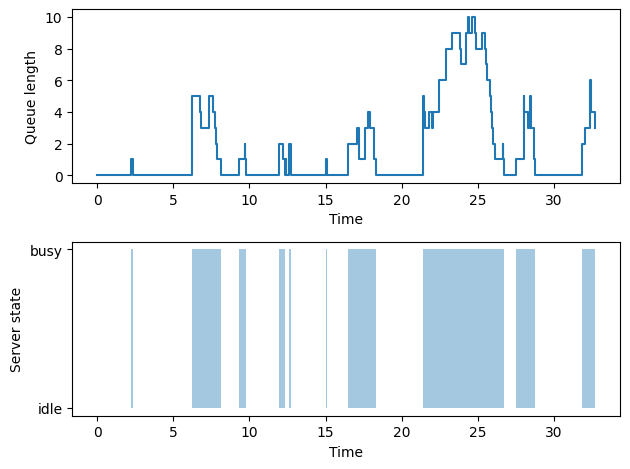

In [200]:
if LOGGED and PLOTTED:
    import matplotlib.pyplot as plt
    log = np.loadtxt( 'mm1-l%d-m%d.csv' % (LAMBDA,MU), delimiter = '\t' )
    plt.subplot( 2, 1, 1 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Queue length' )
    plt.step( log[:200,0], log[:200,2], where='post' )
    plt.subplot( 2, 1, 2 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Server state' )
    plt.yticks([0, 1], ['idle', 'busy'])
    #plt.step( log[:200,0], log[:200,1], where='post' )
    plt.fill_between( log[:200,0], 0, log[:200,1], step="post", alpha=.4 )
    plt.tight_layout()
    plt.show()